## BSI 데이터 추가

## submission

- v1 : bsi + lag_3 제거
- v2 : bsi 
- v3 : bsi + len_df 으로 특정 데이터 제거

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import gc

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import mean_squared_error

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
# 한글 폰트 설치
!git clone https://github.com/namepen/nanum_font.git

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

font_dirs = ['nanum_font', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'NanumGothic'

Cloning into 'nanum_font'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  if __name__ == '__main__':


In [3]:
sub_ver = 1

## Base dataset

In [4]:
df = pd.read_csv('../input/dacon-jeju/201901-202003.csv')
sub = pd.read_csv('../input/dacon-jeju/submission.csv')

In [5]:
def preprocess_df(df):
    # Mapping
    df['CARD_SIDO_NM'] = df['CARD_SIDO_NM'].map(sido_dict).astype('int16')
    df['CARD_CCG_NM'] = df['CARD_CCG_NM'].map(ccg_dict).astype('int16')
    df['HOM_SIDO_NM'] = df['HOM_SIDO_NM'].map(sido_dict).astype('int16')
    df['HOM_CCG_NM'] = df['HOM_CCG_NM'].map(ccg_dict).astype('int16')
    df['STD_CLSS_NM'] = df['STD_CLSS_NM'].map(clss_dict).astype('int16')
    df['AGE'] = df['AGE'].map(age_dict).astype('int16')

    # True or False
    df['SEX_CTGO_CD'] = df['SEX_CTGO_CD'] == 1

    # Float to int
    df['CSTMR_CNT'] = df['CSTMR_CNT'].astype(int)
    df['AMT'] = df['AMT'].astype(int)
    df['FLC'] = df['FLC'].astype('int16')
    df['CNT'] = df['CNT'].astype('int16')

    # 날짜 변경
    df['REG_YYMM'] = pd.to_datetime(df['REG_YYMM'], format='%Y%m')
    return df

In [6]:
# str -> int categorical features
sido_dict = {sido: num for num, sido in enumerate(df['CARD_SIDO_NM'].unique())}
ccg_dict = {ccg: num for num, ccg in enumerate(df['CARD_CCG_NM'].unique())}
clss_dict = {clss: num for num, clss in enumerate(df['STD_CLSS_NM'].unique())}
age_dict = {age: num for num, age in enumerate(df['AGE'].unique())}

df = preprocess_df(df)

In [7]:
# AMT를 날짜별 / 지역별 합산한다
df_sum = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()
df_sum['REG_YYMM'] = pd.to_datetime(df_sum['REG_YYMM'], format='%Y%m')


len_df = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).apply(len).reset_index()
len_20 = df_sum.loc[(df_sum['REG_YYMM'] < '2020-01-01')&(df_sum['REG_YYMM'] >= '2019-10-01')].groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).apply(len).reset_index()

# 전체 데이터가 8개 미만이면서 2020년 데이터를 예측할때 사용할 데이터를 모두 보유하고 있지 않은 데이터는 삭제한다.
len_del = len_df.loc[len_df[0] < 8]
len_del = len_del.merge(len_20, on=['CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
len_del.fillna(0, inplace=True)
len_del = len_del.loc[len_del['0_y'] < 3]
for sido, clss in zip(len_del['CARD_SIDO_NM'], len_del['STD_CLSS_NM']):
    df_sum.drop(df_sum.loc[(df_sum['CARD_SIDO_NM'] == sido)&(df_sum['STD_CLSS_NM'] == clss)].index, inplace=True)


# 테스트할 월별 데이터를 추가한다.
for day in ['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01']:
    add_df =  df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).first().reset_index().copy()
    add_df['REG_YYMM'] = pd.to_datetime(day)
    add_df['AMT'] = -99
    df_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)
    del add_df
df_sum = df_sum.sort_values(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])

# 세달 전 매출액
df_sum['lag_3'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].shift(3)

# 일년 전 매출액
#df_sum['lag_12'] = df_sum.groupby('CARD_SIDO_NM')['AMT'].shift(12)

# 날짜도 변경
df_sum['REG_YYMM'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['REG_YYMM'].shift(3)

# 훈련할 수 없는 19년 1,2,3 월 데이터 제거
df_sum = df_sum.dropna().reset_index(drop=True)

In [8]:
df_sum.tail()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3
10019,2020-04-01,16,33,-99,-99.0
10020,2020-04-01,16,34,-99,-99.0
10021,2020-04-01,16,36,-99,-99.0
10022,2020-04-01,16,37,-99,-99.0
10023,2020-04-01,16,38,-99,-99.0


## BSI dataset

In [9]:
bsi_df = pd.read_csv('../input/dacon-jeju/BSI_external_data.csv')

In [10]:
bsi_df = pd.read_csv('../input/dacon-jeju/BSI_external_data.csv')
bsi_df['REG_YYMM'] = bsi_df['연도'].astype(str) + bsi_df['분기'].apply(lambda x: str(x) if x>= 10 else str(f'0{x}'))
bsi_df['REG_YYMM'] = bsi_df['REG_YYMM'].astype(int)
bsi_df['REG_YYMM'] = pd.to_datetime(bsi_df['REG_YYMM'], format='%Y%m')

bsi_df.drop(columns=['연도', '분기'], inplace=True)
bsi_df['지역'] = bsi_df['지역'].map(sido_dict) # 전국의 데이터는 nan으로 나타남.
bsi_df.rename(columns={'지역': 'CARD_SIDO_NM'}, inplace=True)

# 모델에 넣기 위해 columns 명 수정
bsi_cols = {col: f"bsi_{num}" for num, col in enumerate(bsi_df.columns) if col not in ['CARD_SIDO_NM', 'REG_YYMM']}
bsi_df.rename(columns= bsi_cols, inplace=True)

# 4월은 현재 2분기로 들어가서 데이터가 존재하지 않는다. 따라서 3월의 데이터를 복사해서 해당 달의 데이터로 사용한다.
temp = bsi_df.loc[bsi_df['REG_YYMM'] == pd.to_datetime('202003', format='%Y%m')].copy()
temp['REG_YYMM'] = pd.to_datetime('202004', format='%Y%m')

bsi_df = pd.concat([bsi_df, temp], axis=0)
bsi_df.dropna(inplace= True)

In [11]:
bsi_df.tail()

,CARD_SIDO_NM,bsi_1,bsi_2,bsi_3,bsi_4,bsi_5,bsi_6,bsi_7,bsi_8,bsi_9,...,bsi_25,bsi_26,bsi_27,bsi_28,bsi_29,bsi_30,bsi_31,bsi_32,bsi_33,REG_YYMM
618,11.0,70,78,-1142,70,90,-2857,70,89,-2714,...,103,103,0,93,97,-430,69,88,-2753,2020-04-01
620,12.0,77,84,-909,78,88,-1282,79,91,-1518,...,105,101,380,97,94,309,79,85,-759,2020-04-01
621,13.0,69,81,-1739,65,82,-2615,65,81,-2461,...,110,107,272,98,101,-306,73,80,-958,2020-04-01
622,15.0,70,79,-1285,72,85,-1805,75,86,-1466,...,106,105,94,98,98,0,75,86,-1466,2020-04-01
623,16.0,64,87,-3593,61,98,-6065,63,100,-5873,...,112,107,446,96,95,104,78,88,-1282,2020-04-01


## 외부 데이터셋

In [12]:
def external_data():
    # 외부 데이터 통합
    ex_df = pd.read_csv('../input/dacon-jeju/external_dataset.csv')
    ex_df.drop(columns=ex_df.columns[0], inplace=True)

    # 한글 column명 변경  
    ex_col = {col:f'ex_{num}' for num, col in enumerate(ex_df.columns[2:])}
    ex_df.rename(columns={'지역':'CARD_SIDO_NM'}, inplace=True)
    ex_df.rename(columns=ex_col, inplace = True)

    # REG_YYMM 날짜 type 변경
    ex_df['REG_YYMM'] = pd.to_datetime(ex_df['REG_YYMM'], format='%Y%m')

    # int categorical features로 변경
    ex_df['CARD_SIDO_NM'] = ex_df['CARD_SIDO_NM'].map(sido_dict)
    ex_df.drop(ex_df.loc[ex_df['CARD_SIDO_NM'].isnull()].index, inplace=True) # 전국으로 집계된 데이터 제외
    ex_df['CARD_SIDO_NM'] = ex_df['CARD_SIDO_NM'].astype(int)
    
    for col in ex_df.columns:
        if ex_df[col].dtype == 'float64':
            ex_df[col] = ex_df[col].astype('float32')
        if ex_df[col].dtype == 'int64':
            ex_df[col] = ex_df[col].astype('int32')
    
    
    # ex_col취업자증감 시도 type 변경
    ex_df.loc[ex_df['ex_1'] == '-', 'ex_1'] = '0'
    ex_df['ex_1'] = ex_df['ex_1'].astype(float)

    # 백화점판매액 시도 데이터 수정(null 값 -> -9999)
    ex_df.loc[ex_df['ex_3'] == '-', 'ex_3'] = -9999
    ex_df.loc[ex_df['ex_3'].isnull(), 'ex_3'] = -9999
    ex_df['ex_3'] = ex_df['ex_3'].astype(int)
    ex_df.loc[ex_df['ex_3'] <= 0, 'ex_3'] = -9999
    return ex_df

In [13]:
ex_df = external_data()
ex_df.head()

,REG_YYMM,CARD_SIDO_NM,ex_0,ex_1,ex_2,ex_3,ex_4,ex_5,ex_6,ex_7,...,ex_74,ex_75,ex_76,ex_77,ex_78,ex_79,ex_80,ex_81,ex_82,ex_83
0,2017-01-01,0,717,23.8,91878,-9999,94.199997,102.480003,102.919998,106.059998,...,101.010002,101.940002,100.510002,100.089996,103.099998,102.230003,104.239998,106.940002,86.699997,0.7
1,2017-01-01,1,6705,156.7,1447953,514371,105.300003,102.680000,102.970001,105.900002,...,100.779999,102.129997,101.610001,99.980003,102.639999,102.150002,103.419998,106.300003,103.800003,7.9
2,2017-01-01,2,1732,25.2,250562,82926,94.599998,102.519997,102.889999,105.989998,...,100.080002,102.050003,100.910004,100.000000,102.690002,101.660004,103.839996,106.199997,91.500000,-4.3
3,2017-01-01,3,1436,1.5,140492,-9999,89.699997,102.360001,102.559998,105.660004,...,100.449997,102.230003,100.760002,100.050003,103.080002,102.360001,103.180000,106.230003,88.900002,-11.3
4,2017-01-01,4,747,10.9,151921,74748,89.900002,102.769997,103.089996,106.059998,...,100.910004,101.779999,101.440002,99.989998,102.330002,101.419998,104.209999,107.839996,87.500000,1.2


In [14]:
# 외부 데이터 변수 추가
#df_sum = df_sum.merge(ex_df, on=['REG_YYMM', 'CARD_SIDO_NM'], how='left')

# 외부 데이터 변수 추가
df_sum = df_sum.merge(bsi_df, on=['REG_YYMM', 'CARD_SIDO_NM'], how='left')

# 월 추가
df_sum['month'] = df_sum['REG_YYMM'].dt.month

In [15]:
df_sum.tail()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,bsi_1,bsi_2,bsi_3,bsi_4,bsi_5,...,bsi_25,bsi_26,bsi_27,bsi_28,bsi_29,bsi_30,bsi_31,bsi_32,bsi_33,month
10019,2020-04-01,16,33,-99,-99.0,64.0,87.0,-3593.0,61.0,98.0,...,112.0,107.0,446.0,96.0,95.0,104.0,78.0,88.0,-1282.0,4
10020,2020-04-01,16,34,-99,-99.0,64.0,87.0,-3593.0,61.0,98.0,...,112.0,107.0,446.0,96.0,95.0,104.0,78.0,88.0,-1282.0,4
10021,2020-04-01,16,36,-99,-99.0,64.0,87.0,-3593.0,61.0,98.0,...,112.0,107.0,446.0,96.0,95.0,104.0,78.0,88.0,-1282.0,4
10022,2020-04-01,16,37,-99,-99.0,64.0,87.0,-3593.0,61.0,98.0,...,112.0,107.0,446.0,96.0,95.0,104.0,78.0,88.0,-1282.0,4
10023,2020-04-01,16,38,-99,-99.0,64.0,87.0,-3593.0,61.0,98.0,...,112.0,107.0,446.0,96.0,95.0,104.0,78.0,88.0,-1282.0,4


## Model dataset 

In [16]:
def model_dataset(df_sum):
    # bsi 예측 시기만 적용해보자.
    #df_sum = df_sum.loc[df_sum['month'].isin([1, 4, 7, 23])]
    
    # Define columns
    categorical_features = ['month', 'CARD_SIDO_NM', 'STD_CLSS_NM']
    train_columns = df_sum.columns[1:][(df_sum.columns[1:] != 'AMT')] #&(df_sum.columns[1:] != 'lag_3')

    train_data = df_sum.loc[df_sum['REG_YYMM'] <= '2019-12-31'].reset_index(drop=True)
    test_data = df_sum.loc[df_sum['REG_YYMM'] > '2019-12-31'].reset_index(drop=True)

    train_data.drop(train_data.loc[train_data['lag_3'] == -99].index, inplace=True)
    #train_data.loc[train_data['AMT'] == -99, 'AMT'] = 0
    train_data.drop(train_data.loc[train_data['AMT'] == -99, 'AMT'].index, inplace=True)

    # AMT를 로그 변환 & lag_3도 변환
    #train_data['lag_3'] = np.log1p(train_data['lag_3'])
    
    print(f"Total columns : {len(train_columns)} / ({list(train_columns[:10])})")
    print(f"Train data : {len(train_data)} / Test data : {len(test_data)}")
    return categorical_features, train_columns, train_data, test_data

In [17]:
categorical_features, train_columns, train_data, test_data = model_dataset(df_sum)

Total columns : 37 / (['CARD_SIDO_NM', 'STD_CLSS_NM', 'lag_3', 'bsi_1', 'bsi_2', 'bsi_3', 'bsi_4', 'bsi_5', 'bsi_6', 'bsi_7'])
Train data : 7488 / Test data : 2488


In [18]:
def run_lgb():
    params = {'verbose': 100,
              'learning_rate': 0.015,
              'metric': 'rmse',
              #'bagging_freq': 3
              'boosting_type': 'gbdt',
              'eval_metric': 'rmse',
              'objective': 'tweedie',
              'tweedie_variance_power': 1.1,
              'n_jobs': -1,
             #'objective': 'regression',
              'seed': 42}
    oof_pred = np.zeros(shape=(len(train_data)))
    y_pred = np.zeros(shape=(len(test_data)))

    features = pd.DataFrame()

    kf = KFold(n_splits=6, shuffle=True, random_state=220)

    for num, (tr_idx, val_idx) in enumerate(kf.split(train_data)):
        print('=' * 50)
        print(f'{num+1} fold Train')
        lgb_train = lgb.Dataset(train_data[train_columns].iloc[tr_idx], np.log1p(train_data['AMT'].iloc[tr_idx]), 
                                categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(train_data[train_columns].iloc[val_idx], np.log1p(train_data['AMT'].iloc[val_idx]), 
                              categorical_feature=categorical_features)

        model = lgb.train(params, lgb_train, num_boost_round = 100000, early_stopping_rounds = 200, 
                                 valid_sets = [lgb_train, lgb_valid], verbose_eval = 500)

        oof_pred[val_idx] = model.predict(train_data[train_columns].iloc[val_idx])
        y_pred += model.predict(test_data[train_columns]) / 6 
        features[f'importance_{num}'] = model.feature_importance()

    print('=' * 50)
    print(f"model oof_pred rmse error :{mean_squared_error(np.log1p(train_data['AMT']), oof_pred)**1/2}")
    print('=' * 50)

    features['importance'] = features[[col for col in features.columns if col.startswith('importance')]].mean(axis=1)
    features['columns'] = model.feature_name()
    return model, features, oof_pred, y_pred

In [19]:
model, features, oof_pred, y_pred = run_lgb()

1 fold Train
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[500]	training's rmse: 0.294417	valid_1's rmse: 0.405245
[1000]	training's rmse: 0.206509	valid_1's rmse: 0.378866
[1500]	training's rmse: 0.160744	valid_1's rmse: 0.366759
[2000]	training's rmse: 0.131656	valid_1's rmse: 0.362502
[2500]	training's rmse: 0.111072	valid_1's rmse: 0.360441
[3000]	training's rmse: 0.094586	valid_1's rmse: 0.358617
[3500]	training's rmse: 0.0818925	valid_1's rmse: 0.357248
[4000]	training's rmse: 0.0717118	valid_1's rmse: 0.356017
[4500]	training's rmse: 0.0631124	valid_1's rmse: 0.355536
[5000]	training's rmse: 0.0559271	valid_1's rmse: 0.355005
[5500]	training's rmse: 0.0499711	valid_1's rmse: 0.354477
[6000]	training's rmse: 0.0445483	valid_1's rmse: 0.354341
Early stopping, best iteration is:
[5905]	training's rmse: 0.0454146	valid_1's rmse: 0.354245
2 fold Train
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.287318	valid_1's rmse: 0.454287
[1000]	training's rmse: 0.20534	valid_1's rmse: 0.431316
[1500]	training'

In [20]:
def my_plot(features):
    
    features['columns'] = features['columns'].apply(lambda x: dict(map(reversed, bsi_cols.items()))[x] if 'bsi' in x else x)
    fig, ax= plt.subplots(1,1, figsize=(10, 7))
    sns.barplot(x='importance', y='columns', data=features.sort_values('importance', ascending=False)[:20])
    plt.show()

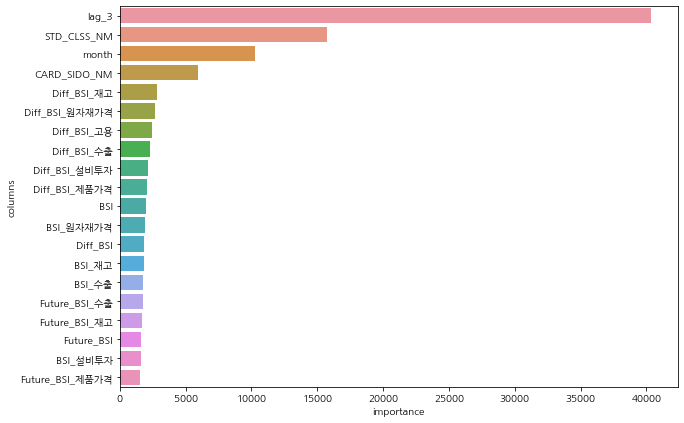

In [21]:
my_plot(features)

## Test dataset

In [22]:
test_data['AMT'] =np.exp(y_pred)
test_data.head()

test_data['REG_YYMM'] = test_data['REG_YYMM'].dt.to_period('M').astype(str).str.replace('-', '')
test_data['REG_YYMM'] = test_data['REG_YYMM'].astype(int)
test_data['REG_YYMM'] += 3
test_data['CARD_SIDO_NM'] = test_data['CARD_SIDO_NM'].map(dict(map(reversed, sido_dict.items())))
test_data['STD_CLSS_NM'] = test_data['STD_CLSS_NM'].map(dict(map(reversed, clss_dict.items())))


In [23]:
test_data.loc[(test_data['CARD_SIDO_NM'] == '강원')&(test_data['STD_CLSS_NM'] == '건강보조식품 소매업')]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,lag_3,bsi_1,bsi_2,bsi_3,bsi_4,bsi_5,...,bsi_25,bsi_26,bsi_27,bsi_28,bsi_29,bsi_30,bsi_31,bsi_32,bsi_33,month
0,202004,강원,건강보조식품 소매업,1.428841e+08,185008768.0,92.0,89.0,326.0,83.0,103.0,...,108.0,100.0,740.0,100.0,100.0,0.0,94.0,97.0,-319.0,1
606,202005,강원,건강보조식품 소매업,1.056229e+08,76505561.0,92.0,89.0,326.0,83.0,103.0,...,108.0,100.0,740.0,100.0,100.0,0.0,94.0,97.0,-319.0,2
1226,202006,강원,건강보조식품 소매업,8.946654e+07,96059012.0,92.0,89.0,326.0,83.0,103.0,...,108.0,100.0,740.0,100.0,100.0,0.0,94.0,97.0,-319.0,3
1854,202007,강원,건강보조식품 소매업,1.283703e+06,-99.0,92.0,89.0,326.0,83.0,103.0,...,108.0,100.0,740.0,100.0,100.0,0.0,94.0,97.0,-319.0,4


In [24]:
sub2 = sub.copy()
sub2.drop(columns='AMT', inplace=True)

sub2 = sub2.merge(test_data[test_data.columns[:4]], on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
sub2.fillna(0, inplace=True)

In [25]:
sub2

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,1.428841e+08
1,1,202004,강원,골프장 운영업,2.608688e+09
2,2,202004,강원,과실 및 채소 소매업,1.344125e+09
3,3,202004,강원,관광 민예품 및 선물용품 소매업,3.079430e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...,...
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.216020e+06
1390,1390,202007,충북,한식 음식점업,1.352223e+06
1391,1391,202007,충북,호텔업,9.312710e+05
1392,1392,202007,충북,화장품 및 방향제 소매업,1.080167e+06


In [26]:
sub2.to_csv(f'submission_bsi_v{sub_ver}.csv', index=False)